# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, February 15, 2017

In [1]:
%matplotlib inline 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

import matplotlib

numpy.random.seed(1234)

## 1. Data Preparation

In [60]:
from sklearn.datasets import make_blobs
n_dim = 2
x_train, y_train = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)
x_test, y_test = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)

In [61]:
y_train_svm = (y_train * 2) - 1
y_test_svm = (y_test * 2) - 1

y_train_lr = y_train.copy()
y_test_lr = y_test.copy()

In [62]:
print (y_train_svm)
print (y_train_lr)

[-1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1
 -1  1  1  1  1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1  1  1  1
 -1  1  1  1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1  1  1  1  1 -1  1 -1 -1  1  1
  1  1  1  1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1  1  1 -1]
[0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0
 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1
 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0]


## 2. Models

### 2.1 Logistic Regression

In [15]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_ + 1e-12) + (1. - y) * numpy.log(1-y_ + 1e-12))
    
    if not avg:
        return d
    return numpy.mean(d)

def logreg_cost(w, x, y):
    return logreg_dist(y, x, w, avg=True)

# Computing the gradient
logreg_rule = grad(logreg_cost)

def _logreg_dist(w, x, y, avg=False):
    return logreg_dist(y, x, w, avg=avg), logreg_rule(w, x, y)

### 2.2 SVM

In [16]:
def svm(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return numpy.sign(y)

def svm_dist(y, x, w, avg=False, pre=False):
    y_ = svm(x, w, pre=True)   # y_ = w.x
    
    if pre:
        return 1. - y_ * y
    
    d = numpy.maximum(0., 1. - y_ * y)  # Hinge loss
    
    if not avg:
        return d
    
    return numpy.sum(d) + numpy.sum(w**2)

def svm_cost(w, x, y):
    return svm_dist(y, x, w, avg=True)

svm_rule = grad(svm_cost)

def _svm_dist(w, x, y, avg=False):
    return svm_dist(y, x, w, avg=avg), svm_rule(w, x, y)

## 3. Let's Train Both

### 3.1 Logistic Regression

In [17]:
w0 = 0.01 * numpy.random.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

logreg_model = scipy.optimize.minimize(_logreg_dist, w0, (x_train, y_train_lr, True), method='L-BFGS-B', jac=True)

w_logreg = logreg_model.x

print (w_logreg)

[-1.87678752 -1.90027034 -0.14056429]


### 3.2 SVM

In [18]:
w0 = 1e-4 * npr.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

svm_model = scipy.optimize.minimize(_svm_dist, w0, (x_train, y_train_svm, True), 
                              method='L-BFGS-B', jac=True, options={'maxls': 100})

w_svm = svm_model.x

print (w_svm)

[-0.79522195 -1.0295208  -0.18665059]


## 4. Visualize LogReg and SVM models

In [19]:
# Visualize data 
def vis_data(x, y = None, c='r', title = ''):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')
    plot.title(title)

In [20]:
def vis_hyperplane(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

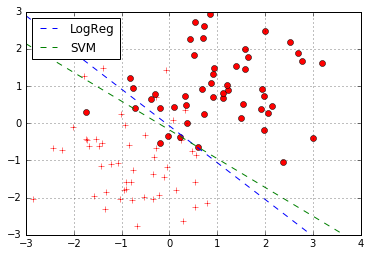

LogReg: -1.9 x_1 + -1.9 x_2 + -0.14 = 0
SVM: -0.80 x_1 + -1.03 x_2 + -0.19 = 0


In [21]:
plot.figure()

vis_data(x_train, y_train_lr, c='r')

plt0 = vis_hyperplane(w_logreg, 'b--')
plt1 = vis_hyperplane(w_svm, 'g--')

plot.legend([plt0, plt1], ['LogReg', 'SVM'],
           loc='best')

plot.show()

print ('LogReg: {:.2} x_1 + {:.2} x_2 + {:.2} = 0'.format(*list(w_logreg)))
print ('SVM: {:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0'.format(*list(w_svm)))

### NOTE: Observe the decision boundaries of LogReg and SVM. Not much difference right? 

## 5. More data

In [63]:
x_train_more, y_train_more = make_blobs(n_samples=10, n_features=n_dim, centers=[[3, 3]], shuffle=True)
x_test_more, y_test_more = make_blobs(n_samples=10, n_features=n_dim, centers=[[3, 3]], shuffle=True)

In [64]:
print (y_train_more)

y_train_more[y_train_more == 0] = 1
y_test_more[y_test_more == 0] = 1

print (y_train_more)

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]


In [65]:
# Append the new data points to the existing set of 100 training and test points

x_train = numpy.vstack((x_train, x_train_more))
x_test = numpy.vstack((x_test, x_test_more))

y_train_lr = numpy.append(y_train_lr, y_train_more)
y_test_lr = numpy.append(y_test_lr, y_test_more)

y_train_svm = numpy.append(y_train_svm, (y_train_more * 2) - 1)
y_test_svm = numpy.append(y_test_svm, (y_test_more * 2) - 1)

In [66]:
print ('Number of training points: ', x_train.shape)

('Number of training points: ', (110, 2))


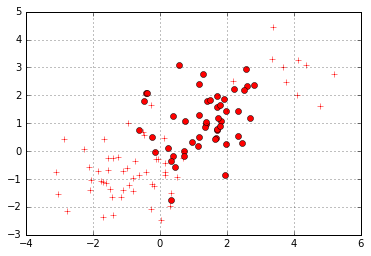

In [67]:
vis_data(x_train, y_train_lr, c='r')

### 5.1 Training

In [68]:
######## Logistic Regression ########
w0 = 0.01 * numpy.random.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

logreg_model = scipy.optimize.minimize(_logreg_dist, w0, (x_train, y_train_lr, True), method='L-BFGS-B', jac=True)

w_logreg = logreg_model.x

print (w_logreg)


####### SVM #######
w0 = 1e-4 * npr.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

svm_model = scipy.optimize.minimize(_svm_dist, w0, (x_train, y_train_svm, True), 
                              method='L-BFGS-B', jac=True, options={'maxls': 100})

w_svm = svm_model.x

print (w_svm)

[-0.31655012 -0.36911198  0.4957013 ]
[-0.46780998 -0.32478056  0.26307967]


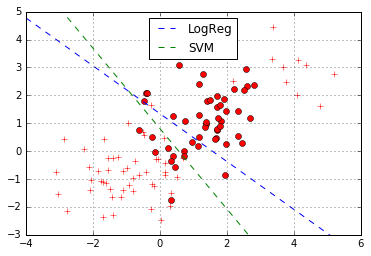

LogReg: -0.32 x_1 + -0.37 x_2 + 0.5 = 0
SVM: -0.47 x_1 + -0.32 x_2 + 0.26 = 0


In [69]:
plot.figure()

vis_data(x_train, y_train_lr, c='r')

plt0 = vis_hyperplane(w_logreg, 'b--')
plt1 = vis_hyperplane(w_svm, 'g--')

plot.legend([plt0, plt1], ['LogReg', 'SVM'],
           loc='best')

plot.show()

print ('LogReg: {:.2} x_1 + {:.2} x_2 + {:.2} = 0'.format(*list(w_logreg)))
print ('SVM: {:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0'.format(*list(w_svm)))

### KEY POINT: Logistic Regression is more sensitive to outliers than SVM

## 6. Differences between Logistic Regression and SVM

### a) Loss/Distance Function

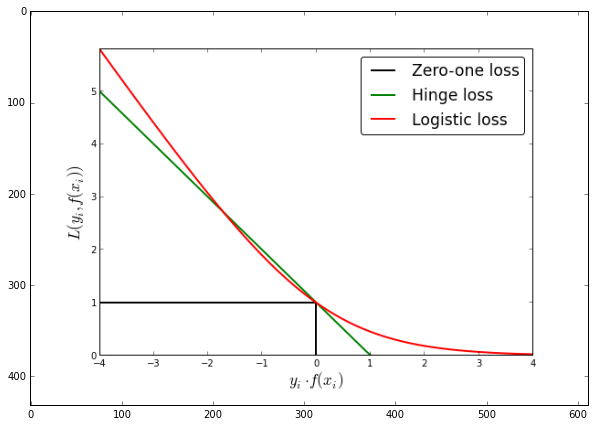

In [72]:
from scipy import misc
plot.figure(figsize=(10, 8))
plot.imshow(misc.imread('loss_functions.png'))

### b) SVM considers only support vectors whereas Logistic Regression considers all the training points. 